Import all the libraries which are used for importing the dataset and creating the network.

In [15]:
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim

Create static variables that will be used later. These variables consists of values such as the rate at which the network learns from the data.

In [16]:
epochs = 1

batch_size_train = 64
batch_size_test = 1000

learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

The following code blocks provides the data sets with handwritten digit data. It converts the images into grayscale with values with the range from 0 to 1.

In [17]:
train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.5,), (0.5,))])),batch_size=batch_size_test, shuffle=True)

Fetches some data as examples for displaying the data structure below.

In [18]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

The following line of code simply outputs the structure of the data. The output here shows that each batch in the training data contains 64 images and that each image has 28x28 pixels dimension.

In [19]:
example_data.shape

torch.Size([64, 1, 28, 28])

The code block below plots different numbers from the dataset to show numbers and different ways people wrote them down. Each image has a ground truth which simply means what number does the image represent. This is a way to show that everyone has a different handwriting and the network should be capable of recognizing most of the numbers.

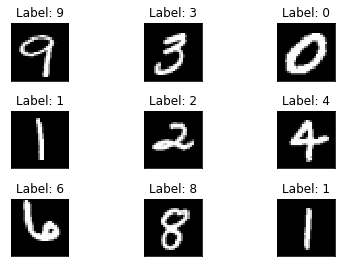

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

The following function simply creates and returns a model that contains 3 layers: a 28x28 input layer, a hidden layer of 50 nodes and an output layer of size 10. The LogSoftmax is for normalizing the output vector to a range between 0 and 1.

In [21]:
def create_model():
    return nn.Sequential(
        nn.Linear(28 * 28, 50),
        nn.ReLU(),
        nn.Linear(50, 10),
        nn.LogSoftmax(1)
    )

The following code block trains the network with the handwritten digit data (train_loader). It iterates over an n amount of epochs. It also iterates over each batch from the train_loader. At each iteration, it adjusts the weights as well as calculating the loss. This allows us to see how accurate is the prediction of each batch. The accuracy is stored in an array which helps to plot the training process of the network.

In [22]:
def train_model(model):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    total = 0
    nr_correct = 0

    accuracy = []
    for n in range(0, epochs):
        for (batch_index, (images, labels)) in enumerate(train_loader):
            images = images.view(images.shape[0], -1)
            result = model(images)

            optimizer.zero_grad()

            loss = criterion(result, labels)
            loss.backward()

            optimizer.step()

            _, predictions = torch.max(result, 1)
            total = images.size(0)
            nr_correct = torch.sum(predictions == labels).item()

            accuracy.append(nr_correct / total)
            
    return accuracy

The purpose of this function create a test model which can be used to compare to the training model. It is used to check if the model generalized to the other data.

In [23]:
def test_model(model, test_loader):
    total = 0
    nr_correct = 0
    
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1)
        result = model(images)
        
        _, predictions = torch.max(result, 1)
        total += images.size(0)
        nr_correct += torch.sum(predictions == labels).item()
                
    return nr_correct / total

The function within the codeblock below uses the information obtained from the training to plot the rate at which the network learns about the data. The plot contains the amount of training batches and the accuracy of the model during the training.

In [24]:
def plot_learning_rate(batch_accuracies):
    fig, ax = plt.subplots()
    ax.plot(
        range(0, len(batch_accuracies)), 
        batch_accuracies
    )

    ax.set_ylim((0, 1))
    ax.set(
        xlabel='training batches', 
        ylabel='accuracy',
        title='Model accuracy during training'
    )

    plt.show()

The following lines of code simply calls out the previously mentioned functions in order to create the model, train it and plot it the information about its accuracy during training.

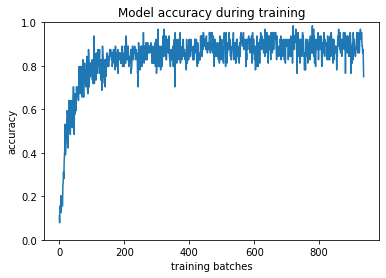

In [25]:
model = create_model()
accuracy = train_model(model)
plot_learning_rate(accuracy)


The function below plots a the accuracy of the networks prediction of a single handwritten number from the test_loader.
The generated graph displays all possible 10 numbers and shows which are the closest numbers that match the handwritten number.

In [26]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.cpu().data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='gray', interpolation='none')
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

The following code block fetches images and labels of the handwritten numbers. It fetches a single number from test_loader and prints it out as an image to allow the user to know which handwritten number the network tried to predict.
Together with the previously mentioned function, this allows to show the number that the network tries to guess together with the graph that displays the network's accuracy.

Predicted Digit = 9


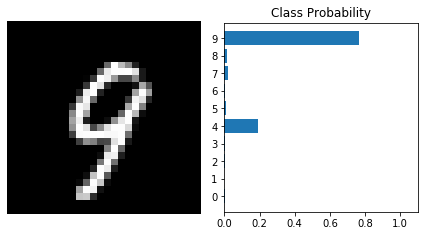

In [28]:
images, labels = next(iter(train_loader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)